# `PulseSimulator` prototype 1

In the first prototype phase we want to figure out the interfaces/functionality for:
- Building a `PulseSimulator` instance with a custom model.
- Simulating a pulse schedule with measurement.

## 0. Imports, and configure to use JAX

In [1]:
import numpy as np
from qiskit import pulse
from qiskit_dynamics.pulse.pulse_simulator import PulseSimulator
from qiskit_dynamics import Solver

# Configure to use JAX internally
# Enables auto-jitting of pulse simulation, so speeds things up
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

# Solver options to pass to PulseSimulator.run
solver_options = {'method': 'jax_odeint', 'atol': 1e-10, 'rtol': 1e-10}

## 1. Instantiating `PulseSimulator` with a `Solver`

Build a `Solver` instance representing a single qubit, configured for pulse simulation.

In [2]:
Z = np.array([[-1., 0.], [0., 1.]])
X = np.array([[0., 1.], [1., 0.]])

r = 0.1

static_ham = 2 * np.pi * 5 * Z / 2
drive_op = 2 * np.pi * r * X / 2

solver = Solver(
    static_hamiltonian=static_ham,
    hamiltonian_operators=[drive_op],
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': 5.},
    dt=0.1,
    rotating_frame=static_ham
)

Instantiate the `PulseSimulator` with the solver. Specifying `subsystem_dims` allows the `PulseSimulator` to know the subsystem dimensions of a composite system.

In [3]:
backend = PulseSimulator(
    solver=solver, 
    subsystem_dims=[2],
    solver_options=solver_options
)

Simulate a schedule. 

Notes:
- Defaults to initial state being the ground state.
- Measurements are projective, occuring right as the acquire command starts.

In [4]:
%%time

from qiskit.pulse import library

sigma = 128
num_samples = 256

schedules = []

for amp in np.linspace(0., 1., 10):
    gauss = pulse.library.Gaussian(
        num_samples, amp, sigma, name="Parametric Gauss"
    )

    with pulse.build() as schedule:
        with pulse.align_right():
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.shift_phase(0.5, pulse.DriveChannel(0))
            pulse.shift_frequency(0.1, pulse.DriveChannel(0))
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.acquire(duration=1, qubit_or_channel=0, register=pulse.MemorySlot(0))
    
    schedules.append(schedule)

job = backend.run(schedules, shots=100)

job.result()

CPU times: user 1.46 s, sys: 75.7 ms, total: 1.53 s
Wall time: 1.52 s


[Result(backend_name='PulseSimulator', backend_version='0.1', qobj_id='None', job_id='96b06c25-5bfa-47a8-9502-e964d6bf254e', success=True, results={'counts': {'0': 100}}, date=2022-11-02T10:37:48.661011, status=None, header=None),
 Result(backend_name='PulseSimulator', backend_version='0.1', qobj_id='None', job_id='96b06c25-5bfa-47a8-9502-e964d6bf254e', success=True, results={'counts': {'0': 94, '1': 6}}, date=2022-11-02T10:37:48.661026, status=None, header=None),
 Result(backend_name='PulseSimulator', backend_version='0.1', qobj_id='None', job_id='96b06c25-5bfa-47a8-9502-e964d6bf254e', success=True, results={'counts': {'0': 67, '1': 33}}, date=2022-11-02T10:37:48.661030, status=None, header=None),
 Result(backend_name='PulseSimulator', backend_version='0.1', qobj_id='None', job_id='96b06c25-5bfa-47a8-9502-e964d6bf254e', success=True, results={'counts': {'0': 38, '1': 62}}, date=2022-11-02T10:37:48.661033, status=None, header=None),
 Result(backend_name='PulseSimulator', backend_versio

## 2. Validation of measurements

If a schedule doesn't have a measurement, an error is raised. 

For now:
- `PulseSimulator.run` only works for a schedule with a single measurement, and outputs counts.
- We can add arguments to `PulseSimulator.run` to allow a user to control how the simulation is done, e.g. getting counts v.s. a state simulation v.s. a propagator simulation.

In [5]:
from qiskit.pulse import library

amp = 1
sigma = 10
num_samples = 64
gauss = pulse.library.Gaussian(num_samples, amp, sigma, name="Parametric Gauss")

with pulse.build() as schedule:
    pulse.play(gauss, pulse.DriveChannel(0))

job = backend.run(
    schedule, 
    shots=100, 
    solver_options=solver_options
)

QiskitError: 'At least one measurement must be present in each schedule.'

## 3. Relabeling subsystems

When building `PulseSimulator` instances from real backends, we will select a subset of qubits. A user should be able to interact with the instance by using the original qubit labels.

In [6]:
solver = Solver(
    static_hamiltonian=static_ham,
    hamiltonian_operators=[drive_op],
    hamiltonian_channels=['d1'],
    channel_carrier_freqs={'d1': 5.},
    dt=0.1,
    rotating_frame=static_ham
)

backend_relabeled = PulseSimulator(solver=solver, subsystem_dims=[2], subsystem_labels=[1])

In [7]:
with pulse.build() as schedule:
    with pulse.align_right():
        pulse.play(gauss, pulse.DriveChannel(1))
        pulse.acquire(duration=1, qubit_or_channel=1, register=pulse.MemorySlot(1))

job = backend_relabeled.run(
    schedule, 
    shots=100, 
    solver_options=solver_options
)

job.result()

[Result(backend_name='PulseSimulator', backend_version='0.1', qobj_id='None', job_id='1a085a0b-3fc9-4790-b9d1-4ae3be473a11', success=True, results={'counts': {'00': 84, '10': 16}}, date=2022-11-02T10:37:50.008633, status=None, header=None)]

Rerun the schedule attempting to measure qubit `0`, which doesn't exist.

In [8]:
with pulse.build() as schedule:
    with pulse.align_right():
        pulse.play(gauss, pulse.DriveChannel(1))
        pulse.acquire(duration=1, qubit_or_channel=0, register=pulse.MemorySlot(1))

job = backend_relabeled.run(
    schedule, 
    shots=100, 
    solver_options=solver_options
)

job.result()

QiskitError: 'Attempted to measure subsystem 0, but it is not in subsystem_list.'

## 4. Running a circuit with pulse definitions

Running a circuit requires having a `meas_map`, and a measurement instructions defined in the `InstructionScheduleMap` in `backend.target`. The use can build their own target, and set `meas_map` as an option, but we've set the defaults as:
- `meas_map` defaults to `[[x] for x in subsystem_labels]`
- the `'measure'` instructions in the `InstructionScheduleMap` default to just an acquire instruction of duration `1` for the given qubit. 

In [9]:
solver = Solver(
    static_hamiltonian=static_ham,
    hamiltonian_operators=[drive_op],
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': 5.},
    dt=0.1,
    rotating_frame=static_ham
)
backend = PulseSimulator(
    solver=solver, 
    solver_options=solver_options
)

Make a circuit.

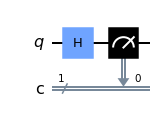

In [10]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(1, 1)
circ.h(0)
circ.measure([0], [0])

circ.draw("mpl")

Add calibration.

In [11]:
with pulse.build() as h_q0:
    pulse.play(pulse.library.Gaussian(duration=256, amp=0.2, sigma=50, name='custom'),
               pulse.DriveChannel(0))

circ.add_calibration('h', [0], h_q0)

Run it.

In [12]:
%time res = backend.run(circ).result()

CPU times: user 624 ms, sys: 12.7 ms, total: 637 ms
Wall time: 623 ms


In [13]:
res

[Result(backend_name='PulseSimulator', backend_version='0.1', qobj_id='None', job_id='9cfa960f-45fb-42c5-98ac-41554e475af4', success=True, results={'counts': {'0': 887, '1': 137}}, date=2022-11-02T10:37:51.197139, status=None, header=None)]

## 5. Running a circuit with pre-defined `InstructionScheduleMap`

Configure a target to instantiate the simulator with.

In [14]:
from qiskit.transpiler import Target

# create target and add gate
target = Target()
inst_sched_map = target.instruction_schedule_map()
inst_sched_map.add('h', qubits=0, schedule=h_q0)

# rebuild same circuit
circ = QuantumCircuit(1, 2)
circ.h(0)
circ.measure([0], [1])

# build pulse simulator
backend = PulseSimulator(
    solver=solver, 
    target=target,
    solver_options=solver_options
)

Note that in the above the default measurement schedule is still being created.

In [15]:
%time res = backend.run(circ).result()

CPU times: user 636 ms, sys: 11.7 ms, total: 647 ms
Wall time: 634 ms


In [16]:
res

[Result(backend_name='PulseSimulator', backend_version='0.1', qobj_id='None', job_id='b912e283-bff3-4a39-ada9-c863d4aac594', success=True, results={'counts': {'00': 894, '10': 130}}, date=2022-11-02T10:37:51.850058, status=None, header=None)]